# Social and Environmental

- Data Cleaning
- Data Visualisation
- Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone
from SPARQLWrapper import SPARQLWrapper, JSON

%matplotlib inline

In [2]:
# Reading the data from social and environmental revisions
# Contains the revisions for all the selected items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/social_environmental_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/social_environmental.csv')

In [3]:
print("Number of Revisions in Social and Environmental Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Social and Environmental Dataset")
print(items.shape)

Number of Revisions in Social and Environmental Dataset
(4883145, 12)
Number of Wikidata Items in Social and Environmental Dataset
(801486, 3)


# Data Cleaning

- Drop uneccessary columns
- Assign types for all edits
- Assign user types for all edits
- Remove rows with empty comments - better to remove after calculating the types in case there are some edge cases which have not been discovered
- Convert timestamps to datetime objects
- (Remove items that contain only bot edits)
- Remove items with editcounts < (If removing rows with empty comments will need to recalculate the edit count and merge with dataset)

In [4]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [5]:
# Method to assign edit types to each revision by using the comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # Converting the comment to lowercase
    # c = comment.decode("utf-8").lower()
    c = comment.lower()
    # print(c)
    editType = '' 
    
    if c == '':
        return editType
    
    if "|" in c:
        # Comments which have |
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            editType = 'undo'
            return editType
        elif 'restore' in cc:
            editType = 'restore'
            return editType
        elif 'wbsetclaimvalue' in cc:
            editType = 'set'
            return editType
        elif 'wbsetlabeldescriptionaliases' in cc:
            editType = 'set'
            return editType
        elif 'wbcreateredirect' in cc:
            editType = 'create'
            return editType
        elif 'merge' in cc:
            editType = 'merge'
            return editType
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                editType = 'create'
                return editType
            elif 'add' in ccc:
                editType = 'add'
                return editType
            elif 'set' in ccc:
                editType = 'set'
                return editType
            elif 'update' in ccc:
                editType = 'update'
                return editType
            elif 'remove' in ccc:
                editType = 'remove'
                return editType
    if 'revert' in c: 
        editType = 'revert'
        return editType  
    elif 'protect' in c:
        editType = 'protect'
        return editType  
    elif 'undid' in c:
        editType = 'undo'
        return editType      
    return editType
        

In [6]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [7]:
rev.shape

(4883145, 9)

In [8]:
# Removing revisions with empty types 
# Removing revisions that either had an empty comment or or an edge case
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [10]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [11]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    u = user[1:].replace("'", "")
    
    userType = ''
    
    if u == "":
        userType = 'Anonymous'
        return userType
    elif u in bots.values:
        userType = 'Bot'
        return userType
    else: 
        userType = 'Registered'
        return userType
    return userType
    

In [12]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [14]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [15]:
editscount = rev['qid'].value_counts()

In [16]:
editscount.describe()

count    799329.000000
mean          6.079448
std          13.261592
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         917.000000
Name: qid, dtype: float64

Removing edits <= 5 will remove more than half of this dataset leaving behind only the top 25%

In [17]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [18]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
305661
Items with No of Edits = 2
196500
Items with No of Edits = 3
69624
Items with No of Edits = 4
27647
Items with No of Edits = 5
30991
Items with No of Edits <= 5
630423


In [19]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [20]:
df_editscount.shape

(168906, 2)

In [21]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [23]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [24]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [25]:
# Sparql Query to get labels using Qids
def get_item_label(qid):
    try:        
        # Specifying the Wikidata SPARQL endpoint
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        
        # Query to access the label for the wikidata item
        sparql.setQuery('PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ?label WHERE {wd:' + qid + ' rdfs:label ?label . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } } LIMIT 1')
        
        # Converting result to JSON format
        sparql.setReturnFormat(JSON)
        result = sparql.query().convert()
        
        # result is in the form of "bindings" which are a list of dictionaries
        # Accessing the value of the label 
        itemLabel = result["results"]["bindings"][0]["label"]["value"]
        
        return itemLabel
    except Exception as ex:
        print(ex)
        return('')

In [26]:
print(df_editscount.head())

        qid  editscount
0  Q3642765         917
1  Q3964154         743
2  Q4504204         726
3   Q534197         702
4     Q1085         657


Need to remove social groups from initial dataset as we are getting communes such as russian or french communes/cities

# Descriptive Statistics

In [28]:
rev['editscount'].describe().astype(int)

count    3686403
mean          45
std           45
min            6
25%           16
50%           54
75%           65
max          917
Name: editscount, dtype: int32

In [29]:
rev['type'].describe()

count     3686403
unique         10
top           add
freq      2328954
Name: type, dtype: object

In [30]:
social_environmental_items = rev['qid'].value_counts()

In [31]:
# converting a series to a dataframe
se_items = pd.DataFrame({'type':social_environmental_items.index, 'count':social_environmental_items.values})

In [32]:
# Items between the median and 75th percentile
se_items[(se_items['count'] >= 54) & (se_items['count'] <= 65)]

,type,count
9335,Q1415047,65
9336,Q1340286,65
9337,Q1162289,65
9338,Q1425482,65
9339,Q258566,65
...,...,...
27282,Q14485867,54
27283,Q181955,54
27284,Q967,54
27285,Q14558856,54


Too many communes

# Statistics for Proxies

In [33]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [34]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

           count
type            
add      2328954
update    625852
remove    382428
create    288080
set        56325
undo        2577
merge       1286
revert       591
restore      304
protect        6


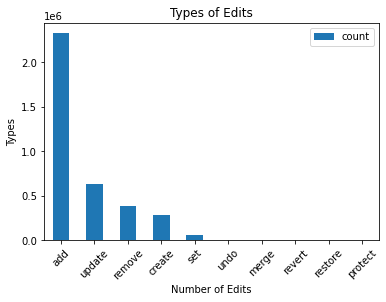

In [35]:
# Plotting the statistics for the proxies/types of edits in the data
ax = ts.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

plt.show()

In [38]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[2, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

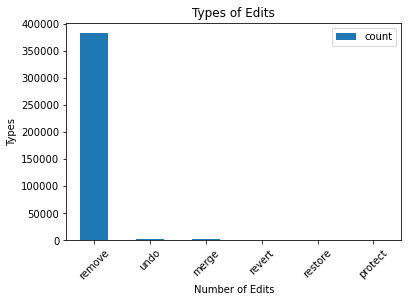

In [39]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

In [43]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
undo      2577
merge     1286
revert     591
restore    304
protect      6


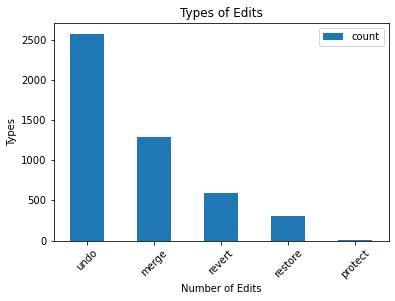

In [44]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

# Statistics for No of Edits

In [45]:
no_of_edits = social_environmental_items.to_numpy()

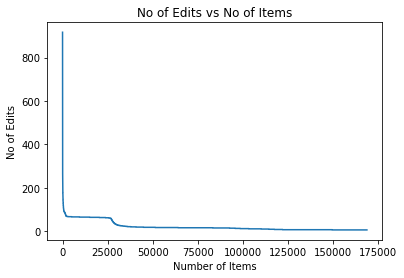

In [46]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

In [47]:
# Top 25% of dataset

# Grouping by Proxies

In [48]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [49]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [50]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [51]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [52]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [53]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [54]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [55]:
proxies = proxies.reset_index()

In [56]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [57]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [58]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [59]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [60]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [62]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,168906.000000,168906.000000,168906.000000,168906.000000,168906.000000,168906.000000,168906.000000,168906.000000
mean,0.003499,0.007614,0.015257,0.001800,0.000036,2.264147,21.825175,2.078541
std,0.091137,0.091890,0.163545,0.054596,0.005960,2.772841,22.660030,1.565215
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,19.000000,3.000000
max,11.000000,4.000000,10.000000,6.000000,1.000000,137.000000,917.000000,51.000000


Text(0, 0.5, 'No of Edits')

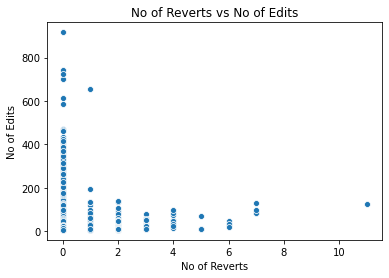

In [63]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")
# No of reverts are very low for highly edited items

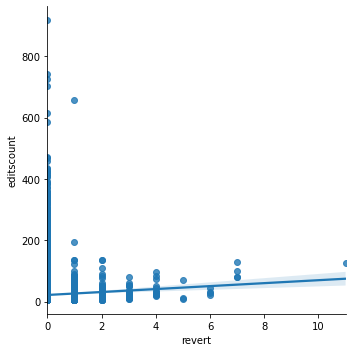

In [64]:
sns.lmplot(x="revert", y="editscount", data=proxies)

In [65]:
corr_matrix = proxies.corr()
corr_matrix
# merge and editscount have a negative correlation

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.026511,0.190656,0.348558,0.141467,0.001544,0.019392,0.242862
merge,0.026511,1.000000,0.020635,0.058635,0.010317,-0.022230,-0.033100,0.099451
undo,0.190656,0.020635,1.000000,0.163356,0.066258,-0.053237,-0.026421,0.135385
restore,0.348558,0.058635,0.163356,1.000000,0.145364,0.022398,0.021402,0.169544
protect,0.141467,0.010317,0.066258,0.145364,1.000000,-0.000926,0.010918,0.076494
remove,0.001544,-0.022230,-0.053237,0.022398,-0.000926,1.000000,-0.072347,-0.264462
editscount,0.019392,-0.033100,-0.026421,0.021402,0.010918,-0.072347,1.000000,-0.117494
userscount,0.242862,0.099451,0.135385,0.169544,0.076494,-0.264462,-0.117494,1.000000


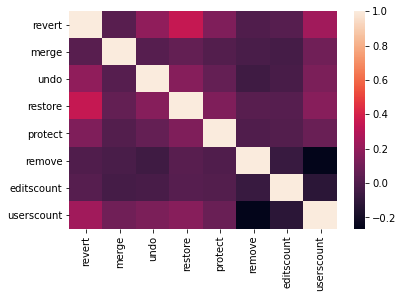

In [66]:
sns.heatmap(corr_matrix)

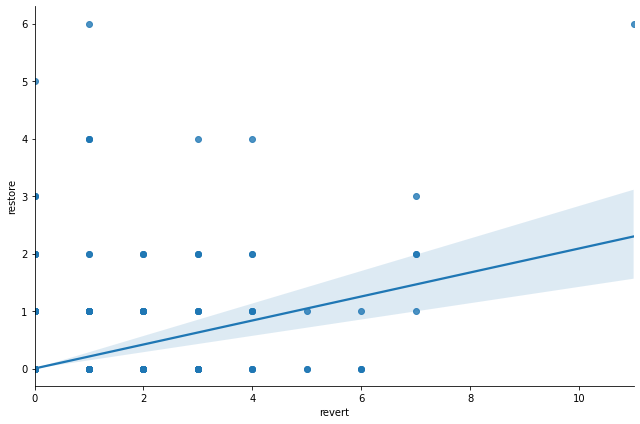

In [67]:
# restore and revert have some correlation - weak positive
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

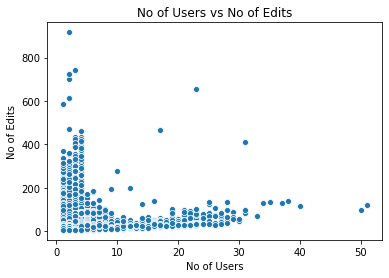

In [68]:
# userscount and editscount have a weak negative correlation - although not very high - it is much higher than others
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

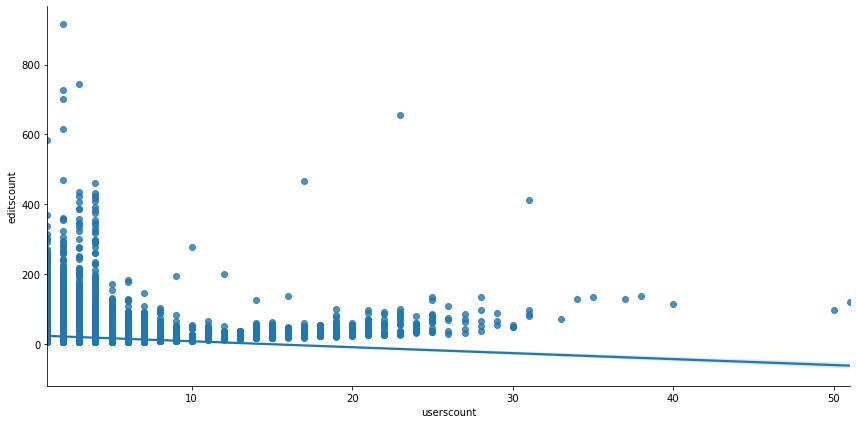

In [69]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=2)

In [70]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
# Removing items with editscount <= 5 
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [71]:
proxies.shape

(83085, 9)